# Violent and Sexual Crime Rates by Municipality: The Netherlands, 2018

In [1]:
# Libararies
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Data & Pre-processing

### Data about registered violent and sexual crime rates
The data is sourced from the Centraal Bureau voor de Statistiek, Den Haag/Heerlen and can be accessed from https://opendata.cbs.nl/statline/portal.html?_la=nl&_catalog=CBS&tableId=84468NED&_theme=395.

In [2]:
# Access the raw crime data 
df = pd.read_csv(r'C:\Users\murat\OneDrive\Belgeler\Projects\NL crime\84468NED_TypedDataSet_30122020_144308.csv', sep=';' , index_col=[0])

In [3]:
# Remove white spaces from the categorical data and set data type as float for some variables
df['WijkenEnBuurten'] = df['WijkenEnBuurten'].str.strip()
df['Gemeentenaam_1'] = df['Gemeentenaam_1'].str.strip()
df['AantalInwoners_5'] = df['AantalInwoners_5'].astype(float)
df['TotaalGeweldsEnSeksueleMisdrijven_22'] = df['TotaalGeweldsEnSeksueleMisdrijven_22'].astype(float)

In [4]:
# Rename column names
columns_to_rename = {
'WijkenEnBuurten': 'Neighborhood',
'Gemeentenaam_1': 'Municipality', 
'SoortRegio_2' : 'Region_type', 
'Codering_3': 'Code',
'Indelingswijziging_4' :'Classification_change', 
'AantalInwoners_5': 'Inhabitants',
'TotaalVermogenVernielingEnGeweld_6': 'Total_assets_destruction_and_violence', 
'TotaalVermogensmisdrijven_7': 'Total Property Crimes',
'TotaalDiefstal_8' : 'Total theft',
'Fietsendiefstal_9' : 'Bicycle theft',
'DiefstalOverigeVervoermiddelen_10': 'Theft_of_other_means_of_transport',
'DiefstalUitVanafVervoermiddelen_11': 'Theft From Means of Transport',
'ZakkenrollerijStraatroofEnBeroving_12': 'Pickpocketing_street_robbery_and_robbery',
'TotaalDiefstalUitWoningSchuurED_13' : 'Total_theft_from_house_and_yard',
'DiefstalUitNietResidentieleGebouwen_14': 'TheftOutNotResidentialBuildings', 
'OverigeDiefstalInbraak_15': 'Other_theft_burglary',
'OverigeVermogensmisdrijven_16': 'Other_property_crimes', 
'TotaalVernielingTegenOpenbareOrde_17': 'Total_destruction_against_public_order',
'TotaalVernieling_18': 'Total_destruction', 
'VernielingAanAuto_19': 'Destruction_to_car', 
'OverigeVernieling_20': 'Other_destruction',
'OverigeVernielingTegenOpenbareOrde_21': 'Other_destruction_against_public_order',
'TotaalGeweldsEnSeksueleMisdrijven_22': 'Total_violence_and_sexual_crimes',
'Mishandeling_23' : 'Mistreatment',
'BedreigingEnStalking_24' : 'Threats_and_stalking', 
'OverigeGeweldsEnSeksueleMisdrijven_25': 'Other_violence_and_sexual_crimes',
'TotaalVermogenVernielingEnGeweld_26': 'Total_assets_destruction_and_violence', 
'TotaalVermogensmisdrijven_27': 'Total_property_crimes',
'TotaalDiefstalUitWoningSchuurED_28' : 'Total_theft_from_home_and_shed',
'VernielingMisdrijfTegenOpenbareOrde_29' : 'Destruction_crime_against_public_order',
'GeweldsEnSeksueleMisdrijven_30': 'Violent_and_sexual_crimes'}

df = df.rename(columns=columns_to_rename)

In [5]:
# Drop rows that contain redundent information for the future calculation
# Drop rows that contain redundent information for the future calculation
df.drop(df[df['Neighborhood'].str.contains('WK')].index, inplace = True)
df.drop(df[df['Neighborhood'].str.contains('GM')].index, inplace = True)
df.shape

(13305, 31)

In [6]:
# Create a dataframe for population by municipality
df_pop_munic = df.groupby('Municipality')['Inhabitants'].sum().to_frame(name='Inhabitants').reset_index()

In [7]:
# Create a dataframe for total number of violent and sexual crime
df_numcrime_munic = df.groupby('Municipality')['Total_violence_and_sexual_crimes'].sum().to_frame(name='Num_of_crime').reset_index()

In [8]:
# Merge dataframes to obtain the crime data
crime_by_munic = pd.merge(df_pop_munic, df_numcrime_munic, how="outer", on=['Municipality'])

In [9]:
# Calculate the crime rate per municipality and assign them as a new column to the crime data
## Multiply the result by 1000 to obtain the crime rate per 1000 inhabitants
crime_by_munic['Crime_rate'] = 1000 * (crime_by_munic['Num_of_crime'].divide(crime_by_munic['Inhabitants']).replace(np.inf, 0))
crime_by_munic['Crime_rate'] = round(crime_by_munic['Crime_rate'], 1)

### Data for geographic information
The data is accessed from www.pdok.nl for the official district boundaries of the Netherlands in 2018

In [10]:
# Access the geographic information
geodata = gpd.read_file(r"C:\Users\murat\Downloads\WijkBuurtkaart_2018_v3\gemeente_2018_v3.shp")
# Examine the data
geodata.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 468 entries, 0 to 467
Columns: 195 entries, GM_CODE to geometry
dtypes: float64(96), geometry(1), int64(95), object(3)
memory usage: 713.1+ KB


In [11]:
# Prepare the geographic data for merging:
## Clean white space and change data type from object to string 
geodata['GM_NAAM'] = geodata['GM_NAAM'].str.strip()
geodata["GM_NAAM"] = geodata["GM_NAAM"].astype('str')

### Merge Data

In [12]:
# Join the geodataframe with the cleaned up csv dataframe
merged = geodata.set_index('GM_NAAM').join(crime_by_munic.set_index('Municipality')).reset_index()
# Save the file as a shape file
merged.to_file("nederland.shp")
# Summary of the data
merged.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 468 entries, 0 to 467
Columns: 198 entries, index to Crime_rate
dtypes: float64(99), geometry(1), int64(95), object(3)
memory usage: 724.1+ KB


In [13]:
# Remove waterbodies from the map
merged = merged[merged['WATER']=='NEE']
# Summary of the data after the removal
merged.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 380 entries, 1 to 467
Columns: 198 entries, index to Crime_rate
dtypes: float64(99), geometry(1), int64(95), object(3)
memory usage: 590.8+ KB


## Analysis
Perform data visualization for Total Violent and Sexual Crime rate per 1000 inhabitants in each municipality.

### Municipalities with the highest crime rates

In [14]:
# Dispaly municipalities with their population and crime rates, sorted by their crime rates
table = crime_by_munic.sort_values('Crime_rate', ascending = False).reset_index(drop=True)
print(table.head(10))
print('---------------------------------------------------------')
print('Number of Municipality:                              ', len(table))
print('---------------------------------------------------------')
# Display summary of crime rates
print('Summary of Crime_rate:\n', table.Crime_rate.describe()[1:])

    Municipality  Inhabitants  Num_of_crime  Crime_rate
0      Amsterdam     853115.0        7489.0         8.8
1  's-Gravenhage     532315.0        4588.0         8.6
2      Rotterdam     638535.0        5415.0         8.5
3      Eindhoven     228880.0        1843.0         8.1
4         Arnhem     157130.0        1269.0         8.1
5      Groningen     202705.0        1555.0         7.7
6     Den Helder      55650.0         409.0         7.3
7        Heerlen      86640.0         609.0         7.0
8       Schiedam      77810.0         545.0         7.0
9        Tilburg     215000.0        1503.0         7.0
---------------------------------------------------------
Number of Municipality:                               380
---------------------------------------------------------
Summary of Crime_rate:
 mean    3.428158
std     1.543160
min     0.600000
25%     2.300000
50%     2.950000
75%     4.225000
max     8.800000
Name: Crime_rate, dtype: float64


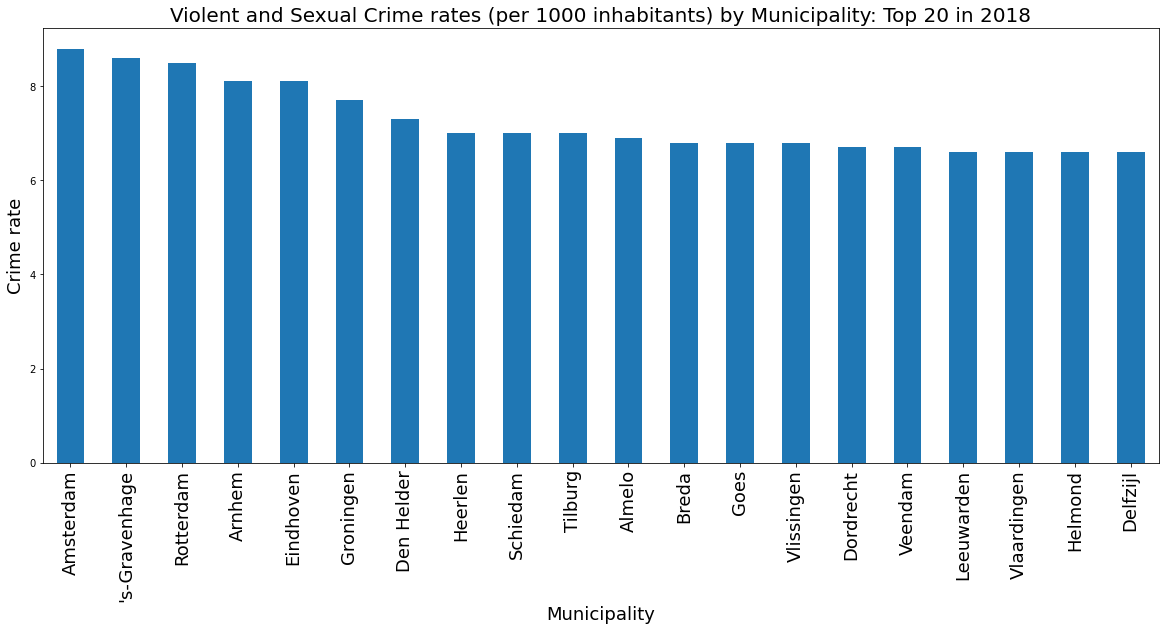

In [15]:
# Display the bar chart figure of the top 20 municipalities of crime rates
table = crime_by_munic.groupby('Municipality')['Crime_rate'].sum().sort_values(ascending=False)
table.head(20).plot(kind= 'bar', legend=False, figsize=(20,8))
plt.title('Violent and Sexual Crime rates (per 1000 inhabitants) by Municipality: Top 20 in 2018', 
          fontweight = 30, fontsize = 20)
plt.xlabel('Municipality', fontsize = 18)
plt.ylabel('Crime rate', fontsize = 18)
plt.xticks(rotation = 90, fontsize = 18)
plt.show()

### Mapping

#### Generating a static choropleth map of the Netherlands using the violent and sexual crime data

C:\Users\murat\anaconda3\lib\site-packages\geopandas\plotting.py:332: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


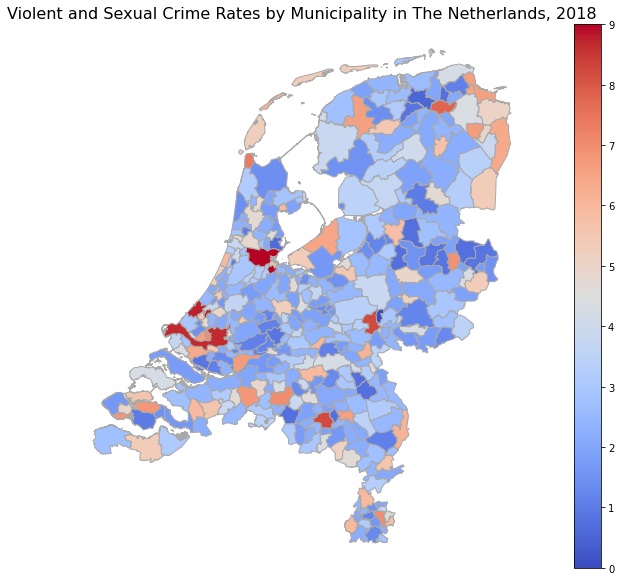

In [16]:
# Determine the size of the figure
fig, ax = plt.subplots(1, 1, figsize=[15,10])

# Create the map
cmap = plt.cm.coolwarm           # for reverse of alternatives use (cmap = cmap.reversed())

nl_map = merged.plot(column='Crime_rate', ax=ax, cmap = cmap, edgecolor='darkgrey',
                      missing_kwds={'color': 'lightgrey', 'edgecolor': 'lightgrey', 
                                    'hatch': '///', 'label': 'Missing values'})
# Do not display information on the axis
ax.axis('off')

# Create a colorbar as a legend
legend = plt.cm.ScalarMappable(cmap= cmap, norm=plt.Normalize(vmin=0, vmax=9))
fig.colorbar(legend)


# Add a title
ax.set_title('Violent and Sexual Crime Rates by Municipality in The Netherlands, 2018', fontsize=16)

# Save figure in the directory and show
fig.savefig('NL_crime_rates.png', dpi=300)
plt.show()

#### Generating an interactive map

In [17]:
# Convert the merged file (Geopandas Dataframe) to GeoJSON format
import json
#Read data to json.
merged_json = json.loads(merged.to_json())

#Convert to String like object.
json_data = json.dumps(merged_json)

In [ ]:
from bokeh.io import curdoc, output_notebook, show, output_file
from bokeh.plotting import figure, save
from bokeh.models import GeoJSONDataSource,  HoverTool, LinearColorMapper, ColorBar
from bokeh.palettes import RdYlBu9 as palette
from bokeh.layouts import row, column

  
# Input GeoJSON source
geosource = GeoJSONDataSource(geojson = json_data)

# Define a sequential color palette (Magma).
#palette = tuple(reversed(palette))

# Instantiate LinearColorMapper to linearly map the data in term of the sequence of colors.
color_mapper = LinearColorMapper(palette = palette)

# Add hover tool
hover = HoverTool(tooltips = [('Mn','@index'), ('Rate', '@Crime_rate')])

#Create color bar. 
color_bar = ColorBar(color_mapper=color_mapper, width = 700, height = 30,
                     border_line_color=None, location = (0,0), orientation = 'horizontal')


#Create figure object.
p = figure(title = 'Violent and sexual crime rates by municipality, 2018', plot_height = 800 , 
           plot_width = 600, x_axis_location=None, y_axis_location=None, toolbar_location = None, tools = [hover])

p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None

#Add patch renderer to figure. 
p.patches('xs','ys', source = geosource,fill_color = {'field' :'Crime_rate', 'transform' : color_mapper},
          line_color = 'lightgrey', line_width = 0.5, fill_alpha = 1)

# Specify layout
p.add_layout(color_bar, 'below')

# Display plot inline in Jupyter notebook
output_notebook()

# output_file("NL_crime_interactive_map.html")
# save(p)

# Display plot
show(p)